# Denver 2016 Bike Share Regression Modeling

## 1. Introduction

The data exploration performed on the Denver Trips dataset indicates weather variables have a significant impact on the number
of checkouts. This section will focus on investigating the use of various regression models on the Trips data when combined with weather variables.

In [1]:
# Import necessary libraries and functions that are needed for the analyses
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline

In [2]:
# taken from Brandon Rhodes's Pandas Tutorial (https://github.com/brandon-rhodes)
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
dF = pd.read_csv("data/2016_Denver_Bike_Trip_ML_Data.gz", dtype = {'Bike_Number' : object}, compression="gzip")

In [4]:
dF.shape

(402962, 20)

In [5]:
dF.head(1)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Hour,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Trip_Distance,Checkout_WeekDay,Checkout_Month,Apparent_Temperature,Cloud_Cover,Humidity,Temperature,Visibility,Wind_Speed
0,Denver B-cycle,1052163,24-hour Kiosk Only (Denver B-cycle),83,2016-01-01,23,Market Street Station,2016-01-01,23:23:00,19th & Market,2,0.26,4,1,9.71,0.0,0.53,14.99,10.0,3.2


In [6]:
dF.drop(['User_Program'], axis = 1, inplace = True)
dF.drop(['User_ID'], axis = 1, inplace = True)
dF.drop(['Bike_Number'], axis = 1, inplace = True)
dF.drop(['Checkout_Date'], axis = 1, inplace = True)
dF.drop(['Checkout_Kiosk'], axis = 1, inplace = True)
dF.drop(['Return_Date'], axis = 1, inplace = True)
dF.drop(['Return_Kiosk'], axis = 1, inplace = True)
dF.drop(['Return_Time'], axis = 1, inplace = True)
dF.drop(['Membership_Type'], axis = 1, inplace = True)

In [7]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402962 entries, 0 to 402961
Data columns (total 11 columns):
Checkout_Hour           402962 non-null int64
Trip_Duration           402962 non-null int64
Trip_Distance           402962 non-null float64
Checkout_WeekDay        402962 non-null int64
Checkout_Month          402962 non-null int64
Apparent_Temperature    402962 non-null float64
Cloud_Cover             402962 non-null float64
Humidity                402962 non-null float64
Temperature             402962 non-null float64
Visibility              402962 non-null float64
Wind_Speed              402962 non-null float64
dtypes: float64(7), int64(4)
memory usage: 33.8 MB


#### Re-arrange columns to set up target class

In [8]:
# re-arrange columns in preparation for training and test data
dF = dF[['Checkout_Month', 'Checkout_WeekDay', 'Cloud_Cover', 'Trip_Duration', 'Trip_Distance', 'Temperature', 
         'Apparent_Temperature', 'Wind_Speed', 'Humidity', 'Visibility', 'Checkout_Hour']]

In [9]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402962 entries, 0 to 402961
Data columns (total 11 columns):
Checkout_Month          402962 non-null int64
Checkout_WeekDay        402962 non-null int64
Cloud_Cover             402962 non-null float64
Trip_Duration           402962 non-null int64
Trip_Distance           402962 non-null float64
Temperature             402962 non-null float64
Apparent_Temperature    402962 non-null float64
Wind_Speed              402962 non-null float64
Humidity                402962 non-null float64
Visibility              402962 non-null float64
Checkout_Hour           402962 non-null int64
dtypes: float64(7), int64(4)
memory usage: 33.8 MB


In [10]:
dML = dF[~((dF.Checkout_Hour == 0)  | (dF.Checkout_Hour == 1)  | (dF.Checkout_Hour == 2)  | (dF.Checkout_Hour == 3)  |
         (dF.Checkout_Hour == 4) | (dF.Checkout_Hour == 5))]

In [11]:
dML.shape

(400407, 11)

In [12]:
data = dML.copy(deep=True)

In [13]:
data = data[['Checkout_Month', 'Checkout_WeekDay', 'Cloud_Cover', 'Trip_Duration', 'Trip_Distance', 'Temperature', 
           'Apparent_Temperature', 'Wind_Speed', 'Humidity', 'Visibility', 'Checkout_Hour']]

In [14]:
array = data.values

In [15]:
X = array[:,0:10]

In [16]:
y = array[:,10]

## Feature Correlations

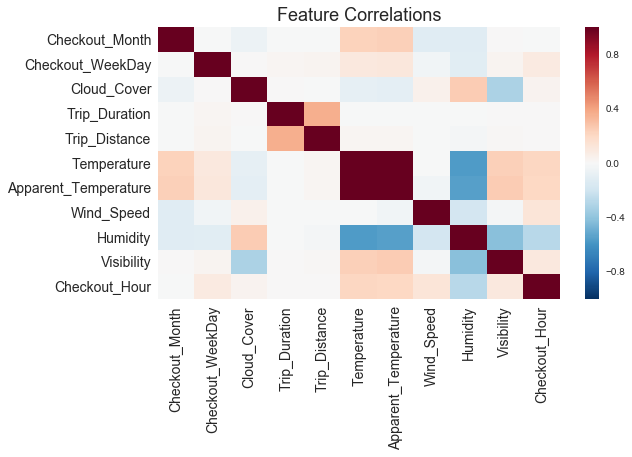

In [17]:
plt.figure(figsize=(9,5))
ax = sns.heatmap(data.corr())
plt.title("Feature Correlations", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [18]:
features = ["Checkout_Month", "Checkout_WeekDay", 'Trip_Duration', 'Trip_Distance',  
            'Cloud_Cover', 'Temperature', 'Apparent_Temperature', 'Wind_Speed', 'Humidity', 'Visibility']
X = data[features]
y = data["Checkout_Hour"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

## 2. Modeling - All Features

#### Plot Feature Importance

In [19]:
def plot_feature_importances(model, plot_title):
    n_features = X.shape[1]
    plt.figure(figsize=(10,5))
    feature_importance = model.feature_importances_
    features_list = features
    feature_importance, features_list = zip(*sorted(zip(feature_importance, features_list)))
    plt.barh(range(len(features_list)), feature_importance, align='center')
    plt.xticks(fontsize=14)
    plt.yticks(np.arange(len(features_list)), features_list, fontsize=14)
    plt.xlabel('Relative Importance', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    plt.title(plot_title + ' Features Importance', fontsize=20)
    plt.show()

#### Get Regression Metrics

In [20]:
def get_regression_metrics(model, actual, predicted):
    regression_metrics = {'R Squared' : metrics.r2_score(actual, predicted)}
    dML_metrics = pd.DataFrame.from_dict(regression_metrics, orient='index')
    dML_metrics.columns = [model]
    return dML_metrics

#### Decision Tree Regression

In [21]:
# Decision Tree Regressor
dtr = DecisionTreeRegressor(random_state=0)
dtr.fit(X_train, y_train)
y_predict = dtr.predict(X_test)
print("Training Set Score: {:.3f}".format(dtr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(dtr.score(X_test, y_test)))
dtr_metrics = get_regression_metrics('Decision Tree Regression', y_test, y_predict)
dtr_metrics

Training Set Score: 1.000
Testing Set Score: 0.997


,Decision Tree Regression
R Squared,0.99703


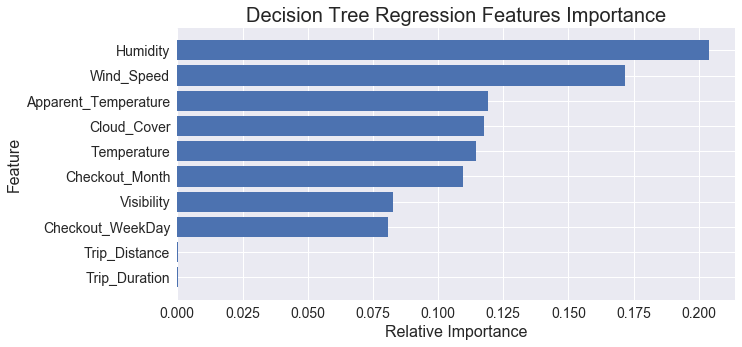

In [22]:
plot_feature_importances(dtr, 'Decision Tree Regression')

#### Linear Regression

In [23]:
# Linear Regression
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)
print("lr.coef_: {}".format(lr.coef_))
print("lr.intercept_: {}".format(lr.intercept_))
print("\nTraining Set Score: {:.3f}".format(lr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(lr.score(X_test, y_test)))
lr_metrics = get_regression_metrics('Linear Regression', y_test, y_predict)
lr_metrics

lr.coef_: [ -5.45062643e-02   1.23016919e-01   1.21158766e-04  -9.96983704e-03
   3.49615236e+00   8.25242870e-03   1.54625652e-02   9.69227489e-02
  -5.17179973e+00   1.34440789e-01]
lr.intercept_: 11.87754300486109

Training Set Score: 0.106
Testing Set Score: 0.102


,Linear Regression
R Squared,0.102423


#### Lasso Regression

In [24]:
# Lasso Regression
lso = linear_model.Lasso(alpha=0.0001)
lso.fit(X_train, y_train)
y_predict = lso.predict(X_test)
print("Training Set Score: {:.3f}".format(lso.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(lso.score(X_test, y_test)))
lso_metrics = get_regression_metrics('Lasso Regression', y_test, y_predict)
lso_metrics

Training Set Score: 0.106
Testing Set Score: 0.102


,Lasso Regression
R Squared,0.102426


#### Ridge Regression

In [25]:
# Ridge Regression
rge = linear_model.Lasso(alpha=0.001)
rge.fit(X_train, y_train)
y_predict = rge.predict(X_test)
print("Training Set Score: {:.3f}".format(rge.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(rge.score(X_test, y_test)))
rge_metrics = get_regression_metrics('Ridge Regression', y_test, y_predict)
rge_metrics

Training Set Score: 0.106
Testing Set Score: 0.102


,Ridge Regression
R Squared,0.102448


#### Random Forest Regression

In [26]:
# Random Forest Regressor
rfr = RandomForestRegressor(random_state=0)
rfr.fit(X_train, y_train)
y_predict = rfr.predict(X_test)
print("Training Set Score: {:.3f}".format(rfr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(rfr.score(X_test, y_test)))
rfr_metrics = get_regression_metrics('Random Forest Regression', y_test, y_predict)
rfr_metrics

Training Set Score: 1.000
Testing Set Score: 0.998


,Random Forest Regression
R Squared,0.99767


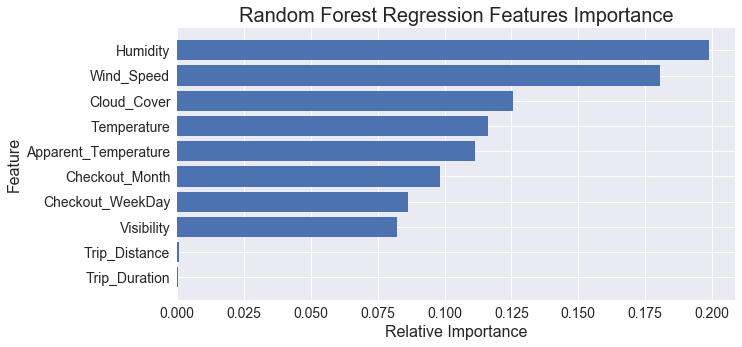

In [27]:
plot_feature_importances(rfr, 'Random Forest Regression')

#### Extra Trees Regression

In [28]:
# Extra Trees Regressor
etr = ExtraTreesRegressor(random_state=0)
etr.fit(X_train, y_train)
y_predict = etr.predict(X_test)
print("Training Set Score: {:.3f}".format(etr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(etr.score(X_test, y_test)))
etr_metrics = get_regression_metrics('Extra Trees Regression', y_test, y_predict)
etr_metrics

Training Set Score: 1.000
Testing Set Score: 0.999


,Extra Trees Regression
R Squared,0.999004


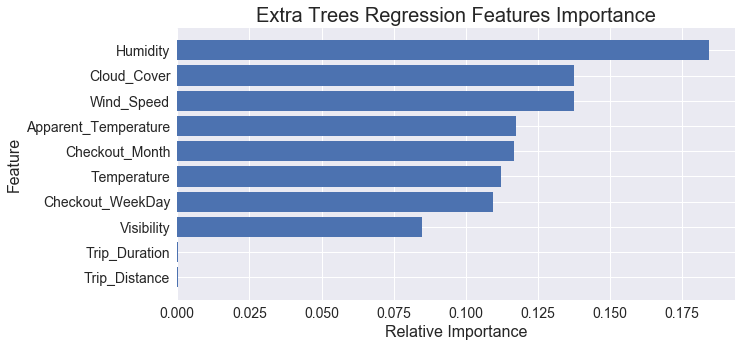

In [29]:
plot_feature_importances(etr, 'Extra Trees Regression')

#### Nearest Neighbors Regression

In [30]:
# Nearest Neighbors Regressor
knr = KNeighborsRegressor(n_neighbors=2)
knr.fit(X_train, y_train)
y_predict = knr.predict(X_test)
print("Training Set Score: {:.3f}".format(knr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(knr.score(X_test, y_test)))
knr_metrics = get_regression_metrics('Nearest Neighbors Regression', y_test, y_predict)
knr_metrics

Training Set Score: 0.913
Testing Set Score: 0.653


,Nearest Neighbors Regression
R Squared,0.652742


#### Bayesian Ridge Regression

In [31]:
# Bayesian Ridge Regressor
brr = linear_model.BayesianRidge()
brr.fit(X_train, y_train)
y_predict = brr.predict(X_test)
print("Training Set Score: {:.3f}".format(brr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(brr.score(X_test, y_test)))
brr_metrics = get_regression_metrics('Bayesion Ridge Regression', y_test, y_predict)
brr_metrics

Training Set Score: 0.106
Testing Set Score: 0.102


,Bayesion Ridge Regression
R Squared,0.102425


## Regression Summary - All Features

In [32]:
# Regression Summary
print("Regression Summary before Feature Selection")
regression_metrics = pd.concat([dtr_metrics, lr_metrics, lso_metrics, rge_metrics, rfr_metrics,
                                etr_metrics, knr_metrics, brr_metrics] , axis=1)
regression_metrics.sort_index()

Regression Summary before Feature Selection


,Decision Tree Regression,Linear Regression,Lasso Regression,Ridge Regression,Random Forest Regression,Extra Trees Regression,Nearest Neighbors Regression,Bayesion Ridge Regression
R Squared,0.99703,0.102423,0.102426,0.102448,0.99767,0.999004,0.652742,0.102425


## 3. Modeling - Selected Features

In [33]:
dF.drop(['Trip_Duration'], axis = 1, inplace = True)
dF.drop(['Trip_Distance'], axis = 1, inplace = True)

In [34]:
data = data[['Checkout_Month', 'Checkout_WeekDay', 'Cloud_Cover', 'Temperature', 
           'Apparent_Temperature', 'Wind_Speed', 'Humidity', 'Visibility', 'Checkout_Hour']]

In [35]:
array = data.values
X = array[:,0:8]
y = array[:,8]

In [36]:
features = ["Checkout_Month", "Checkout_WeekDay",   
            'Cloud_Cover', 'Temperature', 'Apparent_Temperature', 'Wind_Speed', 'Humidity', 'Visibility']
X = data[features]
y = data["Checkout_Hour"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

#### Decision Tree Regression

In [37]:
# Decision Tree Regression
dtr = DecisionTreeRegressor(random_state=0)
dtr.fit(X_train, y_train)
y_predict = dtr.predict(X_test)
print("Training Set Score: {:.3f}".format(dtr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(dtr.score(X_test, y_test)))
dtr_metrics = get_regression_metrics('Decision Tree', y_test, y_predict)
dtr_metrics

Training Set Score: 1.000
Testing Set Score: 0.998


,Decision Tree
R Squared,0.997807


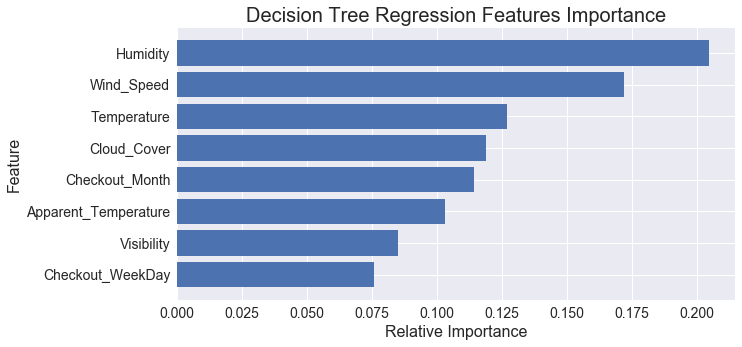

In [38]:
plot_feature_importances(dtr, 'Decision Tree Regression')

#### Linear Regression

In [39]:
# Linear Regression
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)
print("lr.coef_: {}".format(lr.coef_))
print("lr.intercept_: {}".format(lr.intercept_))
print("\nTraining Set Score: {:.3f}".format(lr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(lr.score(X_test, y_test)))
lr_metrics = get_regression_metrics('Linear Regression', y_test, y_predict)
lr_metrics

lr.coef_: [-0.05440446  0.12278287  3.49576538  0.00846443  0.01522559  0.09691592
 -5.17048746  0.13463153]
lr.intercept_: 11.863411405146163

Training Set Score: 0.106
Testing Set Score: 0.102


,Linear Regression
R Squared,0.102364


#### Lasso Regression

In [40]:
# Lasso Regression
lso = linear_model.Lasso(alpha=0.001)
lso.fit(X_train, y_train)
y_predict = lso.predict(X_test)
print("Training Set Score: {:.3f}".format(lso.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(lso.score(X_test, y_test)))
lso_metrics = get_regression_metrics('Lasso Regression', y_test, y_predict)
lso_metrics

Training Set Score: 0.106
Testing Set Score: 0.102


,Lasso Regression
R Squared,0.102387


#### Ridge Regression

In [41]:
# Ridge Regression
rge = linear_model.Lasso(alpha=0.001)
rge.fit(X_train, y_train)
y_predict = rge.predict(X_test)
print("Training Set Score: {:.3f}".format(rge.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(rge.score(X_test, y_test)))
rge_metrics = get_regression_metrics('Ridge Regression', y_test, y_predict)
rge_metrics

Training Set Score: 0.106
Testing Set Score: 0.102


,Ridge Regression
R Squared,0.102387


#### Random Forest Regression

In [42]:
# Random Forest Regression
rfr = RandomForestRegressor(random_state=0)
rfr.fit(X_train, y_train)
y_predict = rfr.predict(X_test)
print("Training Set Score: {:.3f}".format(rfr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(rfr.score(X_test, y_test)))
rfr_metrics = get_regression_metrics('Random Forest Regression', y_test, y_predict)
rfr_metrics

Training Set Score: 1.000
Testing Set Score: 0.998


,Random Forest Regression
R Squared,0.997989


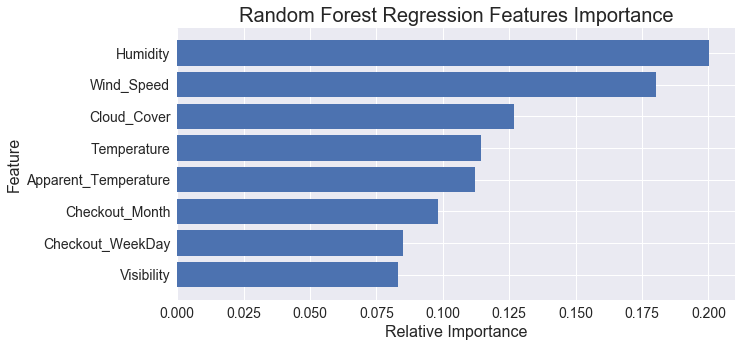

In [43]:
plot_feature_importances(rfr, 'Random Forest Regression')

#### Extra Trees Regression

In [44]:
# Extra Trees Regression
etr = ExtraTreesRegressor(random_state=0)
etr.fit(X_train, y_train)
y_predict = etr.predict(X_test)
print("Training Set Score: {:.3f}".format(etr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(etr.score(X_test, y_test)))
etr_metrics = get_regression_metrics('Extra Trees Regression', y_test, y_predict)
etr_metrics

Training Set Score: 1.000
Testing Set Score: 0.999


,Extra Trees Regression
R Squared,0.999011


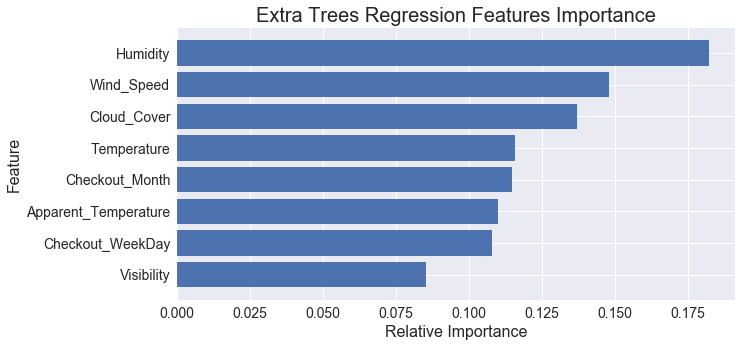

In [45]:
plot_feature_importances(etr, 'Extra Trees Regression')

#### Nearest Neighbors Regression

In [46]:
# Nearest Neighbors Regression
knr = KNeighborsRegressor(n_neighbors=2)
knr.fit(X_train, y_train)
y_predict = knr.predict(X_test)
print("Training Set Score: {:.3f}".format(knr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(knr.score(X_test, y_test)))
knr_metrics = get_regression_metrics('Nearest Neighbors Regression', y_test, y_predict)
knr_metrics

Training Set Score: 1.000
Testing Set Score: 0.997


,Nearest Neighbors Regression
R Squared,0.997435


#### Bayesian Ridge Regression

In [47]:
# Bayesian Ridge Regression
brr = linear_model.BayesianRidge()
brr.fit(X_train, y_train)
y_predict = brr.predict(X_test)
print("Training Set Score: {:.3f}".format(brr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(brr.score(X_test, y_test)))
brr_metrics = get_regression_metrics('Bayesion Ridge Regression', y_test, y_predict)
brr_metrics

Training Set Score: 0.106
Testing Set Score: 0.102


,Bayesion Ridge Regression
R Squared,0.102365


## Regression Summary - Selected Features

In [48]:
# Regression Summary
print("Regression Summary after Feature Selection")
regression_metrics = pd.concat([dtr_metrics, lr_metrics, lso_metrics, rge_metrics, rfr_metrics,
                                etr_metrics, knr_metrics, brr_metrics] , axis=1)
regression_metrics.sort_index()

Regression Summary after Feature Selection


,Decision Tree,Linear Regression,Lasso Regression,Ridge Regression,Random Forest Regression,Extra Trees Regression,Nearest Neighbors Regression,Bayesion Ridge Regression
R Squared,0.997807,0.102364,0.102387,0.102387,0.997989,0.999011,0.997435,0.102365


## 4. Summary

The Decision Tree, Random Forest, Extra Trees and Nearest Neighbors models fit the data extremely well. The Linear, Lasso, Ridge and Bayesian Ridge models don't fit well at all suggesting that the data is not linearly distributed.